In [1]:
# load the model from the file "sbm3x3_pclam_roc_0.210_auc_0.860"
import torch
from torch_geometric.utils import dropout_node, contains_isolated_nodes, is_undirected, contains_self_loops, is_undirected, to_undirected, k_hop_subgraph, coalesce, subgraph, to_dense_adj
from torch.autograd import grad
from torch_geometric.transforms import TwoHop
from torch_geometric.data import Data
from sklearn.metrics import roc_curve, roc_auc_score
import json
import os
import numpy as np
import time
from copy import deepcopy

from math import floor

import sys
if '..' not in sys.path:
    sys.path.insert(0, '..')
from transformation import RealNVP
import transformation as tr
from datasets.import_dataset import import_dataset, load_data_GGAD
import clamiter as ci
from utils import utils
from utils.plotting import *
from trainer import Trainer
from tests import test_no_duplicacy, test_get_fat_ds_test, test_densify_test_from_train
from scripts.scripting_utils import print_prior_training_stats
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)
cpu = torch.device("cpu")

%load_ext autoreload
%autoreload 2


Using device: cuda


/home/user/Documents/danny/AAAI_pieclam/tests/../datasets/import_dataset.py:410: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403378171/work/torch/csrc/utils/tensor_new.cpp:275.)
  edge_index = torch.tensor(adj.nonzero(), dtype=torch.long)
/home/user/anaconda3/envs/piegam/lib/python3.11/site-packages/torch_geometric/edge_index.py:784: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403378171/work/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  return torch.sparse_csr_tensor(




/home/user/Documents/danny/AAAI_pieclam/tests/../trainer.py:415:::  
 starting optimization of piegam on ellipticGGAD on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 30,
        "dim_attr": 93,
        "s_reg": 0.0,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 3e-06,
        "n_iter": 500,
        "early_stop": 0
    },
    "prior_opt": {
        "n_iter": 1300,
        "lr": 2e-06,
        "noise_amp": 0.05,
        "weight_decay": 0.1,
        "early_stop": 0
    },
    "back_forth": {
        "n_back_forth": 5,
        "scheduler_step_size": 1,
        "scheduler_gamma": 0.5,
        "early_stop_fit": 0,
        "first_func_in_fit": "fit_feats"
    }
}


/home/user/Documents/danny/AAAI_pieclam/tests/../trainer.py:420:::  
 train_model_on_params, initializing feats with small_gaus


/home/user/Documents/danny/AAAI_pieclam/tests/../trai

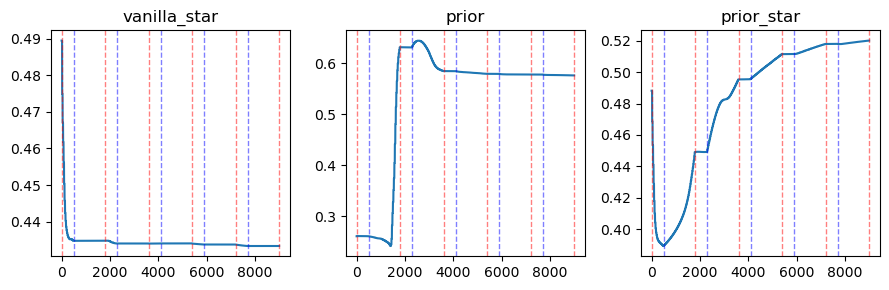



/home/user/Documents/danny/AAAI_pieclam/tests/../clamiter.py:663:::  
fit end, no early stopping


/home/user/Documents/danny/AAAI_pieclam/tests/../trainer.py:502:::  
train_model_on_params on piegam ellipticGGAD 
took 495.16659593582153 seconds


/home/user/Documents/danny/AAAI_pieclam/tests/../trainer.py:504:::  


FINISHED train model on params 





In [2]:

model_name = 'piegam'
ds_name = 'ellipticGGAD'
#! problem with something to do with attr with reddit and elliptic
ds = import_dataset(ds_name)
fat_ds = TwoHop()(ds)
fat_ds.edge_attr = torch.ones(fat_ds.edge_index.shape[1]).bool()

if ds_name in ['Flickr', 'ACM', 'BlogCatalog']:
    ds_to_use = ds
elif ds_name in ['redditGGAD', 'photoGGAD', 'ellipticGGAD']:
    ds_to_use = fat_ds
else:
    raise ValueError('ds_name not recognized')


losseses = []
acc_testses = []
acc_valses = []
for first_func in ['fit_feats']:
    for model_name in ['piegam']:
        config_triplets = [
            ['clamiter_init', 'dim_feat', 30],
            ['clamiter_init', 'dim_attr', 100],
            # ['feat_opt','n_iter', 100],
            # ['prior_opt', 'n_iter', 200],
            ['feat_opt', 'lr', 3e-6],
            ['prior_opt', 'lr', 2e-6],
            ['prior_opt', 'noise_amp', 0.05],
            ['back_forth', 'n_back_forth', 5],
            ['back_forth', 'scheduler_step_size', 1],
            ['back_forth', 'scheduler_gamma', 0.5],
            ['back_forth', 'first_func_in_fit', first_func]
        ]



        trainer_anomaly = Trainer(
            model_name=model_name,
            device=device,
            dataset=ds_to_use.clone(),
            attr_opt=True,
            task='anomaly',
            mighty_configs_dict=True,
            config_triplets_to_change=config_triplets
        )

        losses, acc_test, acc_val = trainer_anomaly.train(
            init_type='small_gaus',
            init_feats=True,
            acc_every=20,
            plot_every=-1,
            verbose=True,
            verbose_in_funcs=False
        )
        losseses.append(losses)
        acc_testses.append(acc_test)
        acc_valses.append(acc_val)

del ds, fat_ds



In [ ]:
plot_test_accuracies(acc_testses[0], n_iter_1st=trainer_anomaly.configs_dict['feat_opt']['n_iter'], n_iter_2nd=trainer_anomaly.configs_dict['prior_opt']['n_iter'], n_back_forth=trainer_anomaly.configs_dict['back_forth']['n_back_forth'])
#todo: test ieclam and bigclam and test distance.

a=0

In [ ]:
a=0

In [ ]:
#todo: now the most important job is to put all of the datasets on the server and do cross validation to see the number of communitieis. so number of communitiies then mpnn on the vanilla

# Find Densification Condition

In [ ]:
# -- COMPARE LOSSES WITH WITHOUT DENSIFICATION  -----
#? REDDIT
config_triplets = [
    ['feat_opt', 'n_iter', 20000],
    ['feat_opt', 'lr', 0.000001],
    ]

slim_reddit_iegam_losses, slim_reddit_iegam_anomaly_auc, slim_reddit_iegam_link_auc = ad.classify_anomaly_link_earlystop(
    'redditGGAD', 
    'iegam', 
    config_triplets_clam=config_triplets,
    use_fat=False,
    percentage_of_dyads_to_omit=0,
    device=device,
    verbose=False
    )

fat_reddit_iegam_losses, fat_reddit_iegam_anomaly_auc, fat_reddit_iegam_link_auc = ad.classify_anomaly_link_earlystop(
    'redditGGAD', 
    'iegam', 
    config_triplets_clam=config_triplets,
    use_fat=True,
    percentage_of_dyads_to_omit=0,
    device=device,
    verbose=False
    )

#? PHOTO
slim_photo_iegam_losses, slim_photo_iegam_anomaly_auc, slim_photo_iegam_link_auc = ad.classify_anomaly_link_earlystop(
    'photoGGAD', 
    'iegam', 
    config_triplets_clam=config_triplets,
    use_fat=False,
    percentage_of_dyads_to_omit=0,
    device=device,
    verbose=False
    )

fat_photo_iegam_losses, fat_photo_iegam_anomaly_auc, fat_photo_iegam_link_auc = ad.classify_anomaly_link_earlystop(
    'photoGGAD', 
    'iegam', 
    config_triplets_clam=config_triplets,
    use_fat=True,
    percentage_of_dyads_to_omit=0,
    device=device,
    verbose=False
    )

#? ELLIPTIC
slim_elliptic_iegam_losses, slim_elliptic_iegam_anomaly_auc, slim_elliptic_iegam_link_auc = ad.classify_anomaly_link_earlystop(
    'ellipticGGAD', 
    'iegam', 
    config_triplets_clam=config_triplets,
    use_fat=False,
    percentage_of_dyads_to_omit=0,
    device=device,
    verbose=False
    )

fat_elliptic_losses, fat_elliptic_iegam_anomaly_auc, fat_elliptic_iegam_link_auc = ad.classify_anomaly_link_earlystop(
    'ellipticGGAD', 
    'iegam', 
    config_triplets_clam=config_triplets,
    use_fat=True,
    percentage_of_dyads_to_omit=0,
    device=device,
    verbose=False
    )

#? BlogCatalog
slim_blog_iegam_losses, slim_blog_iegam_anomaly_auc, slim_blog_iegam_link_auc = ad.classify_anomaly_link_earlystop(
    'BlogCatalog', 
    'iegam', 
    config_triplets_clam=config_triplets,
    use_fat=False,
    percentage_of_dyads_to_omit=0,
    device=device,
    verbose=False
    )

fat_blog_iegam_losses, fat_blog_iegam_anomaly_auc, fat_blog_iegam_link_auc = ad.classify_anomaly_link_earlystop(
    'BlogCatalog', 
    'iegam', 
    config_triplets_clam=config_triplets,
    use_fat=True,
    percentage_of_dyads_to_omit=0,
    device=device,
    verbose=False
    )
#? Flickr
slim_flickr_iegam_losses, slim_flickr_iegam_anomaly_auc, slim_flickr_iegam_link_auc = ad.classify_anomaly_link_earlystop(
    'Flickr', 
    'iegam', 
    config_triplets_clam=config_triplets,
    use_fat=False,
    percentage_of_dyads_to_omit=0,
    device=device,
    verbose=False
    )

fat_flickr_iegam_losses, fat_flickr_iegam_anomaly_auc, fat_flickr_iegam_link_auc = ad.classify_anomaly_link_earlystop(
    'Flickr', 
    'iegam', 
    config_triplets_clam=config_triplets,
    use_fat=True,
    percentage_of_dyads_to_omit=0,
    device=device,
    verbose=False
    )

#? ACM
slim_acm_iegam_losses, slim_acm_iegam_anomaly_auc, slim_acm_iegam_link_auc = ad.classify_anomaly_link_earlystop(
    'ACM', 
    'iegam', 
    config_triplets_clam=config_triplets,
    use_fat=False,
    percentage_of_dyads_to_omit=0,
    device=device,
    verbose=False
    )

fat_acm_iegam_losses, fat_acm_iegam_anomaly_auc, fat_acm_iegam_link_auc = ad.classify_anomaly_link_earlystop(
    'ACM', 
    'iegam', 
    config_triplets_clam=config_triplets,
    use_fat=True,
    percentage_of_dyads_to_omit=0,
    device=device,
    verbose=False
    )


#todo: make the percentage of edges to omit a function of the average DEGREE or something. not the number of edges because a graph can have many nodes and many edges and little nodes and many edges...


In [ ]:

# save everything!





#todo:
#0. right now: doing the link prediction on the server
#1. plot the loss compared to anomaly accuracy plot the link prediction compared to 
#2. read the output os the cheating to see if there is a pattern if not, try 100 feats 1000 prior and try to find some number for n_back_forth


# we want to plot loss compared to link accuracy. find them from 

In [ ]:
max_

In [ ]:
import numpy as np


fat_reddit_auc = np.array(fat_reddit_iegam_anomaly_auc['vanilla_star'])
expanded_fat_reddit_auc = (np.repeat(fat_reddit_auc, 10) - np.mean(fat_reddit_auc) )* 1000000000
slim_reddit_auc = np.array(slim_reddit_iegam_anomaly_auc['vanilla_star'])
expanded_slim_reddit_auc = (np.repeat(slim_reddit_auc, 10) - np.mean(slim_reddit_auc)) * 1000000000
    
fat_photo_auc = np.array(fat_photo_iegam_anomaly_auc['vanilla_star'])
expanded_fat_photo_auc = (np.repeat(fat_photo_auc, 10) - np.mean(fat_photo_auc) )* 1000000000
slim_photo_auc = np.array(slim_photo_iegam_anomaly_auc['vanilla_star'])
expanded_slim_photo_auc = (np.repeat(slim_photo_auc, 10) - np.mean(slim_photo_auc)) * 1000000000

fat_elliptic_auc = np.array(fat_elliptic_iegam_anomaly_auc['vanilla_star'])
expanded_fat_elliptic_auc = (np.repeat(fat_elliptic_auc, 10) - np.mean(fat_elliptic_auc)) * 1000000000
slim_elliptic_auc = np.array(slim_elliptic_iegam_anomaly_auc['vanilla_star'])
expanded_slim_elliptic_auc = (np.repeat(slim_elliptic_auc, 10) - np.mean(slim_elliptic_auc)) * 1000000000

fat_blog_auc = np.array(fat_blog_iegam_anomaly_auc['vanilla_star'])
expanded_fat_blog_auc = (np.repeat(fat_blog_auc, 10) - np.mean(fat_blog_auc)) * 1000000000
slim_blog_auc = np.array(slim_blog_iegam_anomaly_auc['vanilla_star'])
expanded_slim_blog_auc = (np.repeat(slim_blog_auc, 10) - np.mean(slim_blog_auc)) * 1000000000

fat_flickr_auc = np.array(fat_flickr_iegam_anomaly_auc['vanilla_star'])
expanded_fat_flickr_auc = (np.repeat(fat_flickr_auc, 10) - np.mean(fat_flickr_auc)) * 1000000000
slim_flickr_auc = np.array(slim_flickr_iegam_anomaly_auc['vanilla_star'])
expanded_slim_flickr_auc = (np.repeat(slim_flickr_auc, 10) - np.mean(slim_flickr_auc)) * 1000000000
    
fat_acm_auc = np.array(fat_acm_iegam_anomaly_auc['vanilla_star'])
expanded_fat_acm_auc = (np.repeat(fat_acm_auc, 10) - np.mean(fat_acm_auc)) * 1000000000
slim_acm_auc = np.array(slim_acm_iegam_anomaly_auc['vanilla_star'])
expanded_slim_acm_auc = (np.repeat(slim_acm_auc, 10) - np.mean(slim_acm_auc)) * 1000000000








In [ ]:
max(fat_flickr_iegam_anomaly_auc['vanilla_star'])

In [ ]:

def plot_shit(iter, losses, aucs):

    plt.figure()
    if losses:
        plt.plot(100*np.array(slim_reddit_iegam_losses[iter:]), label='loss_slim_reddit_iegam')
        plt.plot(50*np.array(fat_reddit_iegam_losses[iter:]), label='loss_fat_reddit_iegam')
    if aucs:
        plt.plot(expanded_fat_reddit_auc[iter:], label='expanded_fat_reddit_auc')
        plt.plot(expanded_slim_reddit_auc[iter:], label='expanded_slim_reddit_auc')
    plt.legend()
    plt.title('reddit')

    plt.figure()
    if losses:
        plt.plot(100*np.array(slim_photo_iegam_losses[iter:]), label='loss_slim_photo_iegam')
        plt.plot(50*np.array(fat_photo_iegam_losses[iter:]), label='loss_fat_photo_iegam')
    if aucs:
        plt.plot(expanded_fat_photo_auc[iter:], label='expanded_fat_photo_auc')
        plt.plot(expanded_slim_photo_auc[iter:], label='expanded_slim_photo_auc')
    plt.legend()
    plt.title('photo')

    plt.figure()
    if losses:
        plt.plot(100*np.array(slim_elliptic_iegam_losses[iter:]), label='loss_slim_elliptic_iegam')
        plt.plot(50*np.array(fat_elliptic_losses[iter:]), label='loss_fat_elliptic_iegam')
    if aucs:
        plt.plot(expanded_fat_elliptic_auc[iter:], label='expanded_fat_elliptic_auc')
        plt.plot(expanded_slim_elliptic_auc[iter:], label='expanded_slim_elliptic_auc')
    plt.legend()
    plt.title('elliptic')

    plt.figure()
    if losses:
        plt.plot(100*np.array(slim_blog_iegam_losses[iter:]), label='loss_slim_blog_iegam')
        plt.plot(50*np.array(fat_blog_iegam_losses[iter:]), label='loss_fat_blog_iegam')
    if aucs:
        plt.plot(expanded_fat_blog_auc[iter:], label='expanded_fat_blog_auc')
        plt.plot(expanded_slim_blog_auc[iter:], label='expanded_slim_blog_auc')
    plt.legend()
    plt.title('blogcatalog')

    plt.figure()
    if losses:
        plt.plot(100*np.array(slim_flickr_iegam_losses[iter:]), label='loss_slim_flickr_iegam')
        plt.plot(50*np.array(fat_flickr_iegam_losses[iter:]), label='loss_fat_flickr_iegam')
    if aucs:
        plt.plot(expanded_fat_flickr_auc[iter:], label='expanded_fat_flickr_auc')
        plt.plot(expanded_slim_flickr_auc[iter:], label='expanded_slim_flickr_auc')
    plt.legend()
    plt.title('flickr')

    plt.figure()
    if losses:
        plt.plot(100*np.array(slim_acm_iegam_losses[iter:]), label='loss_slim_acm_iegam')
        plt.plot(50*np.array(fat_acm_iegam_losses[iter:]), label='loss_fat_acm_iegam')
    if aucs:
        plt.plot(expanded_fat_acm_auc[iter:], label='expanded_fat_acm_auc')
        plt.plot(expanded_slim_acm_auc[iter:], label='expanded_slim_acm_auc')
    plt.legend()
    plt.title('acm')

# when it finished i want to see if the peak of the link vals 
# should remove more edges


# if it improves losses then use it if not, don't.... something you can check for every ds

plot_shit(iter=200,aucs=True, losses=True)


In [ ]:
# run the i want to see when was the average early stop happening in prior and fit feats


# Overfitting link prediction for early stop

In [ ]:
plt.plot(losses_iegam_flickr, label='iegam_flickr')
plt.plot(_iegam_flickr, label='iegam_amazon')

In [ ]:

config_triplets_gam = []
config_triplets_prior = []
ad.anomaly_detection_unsupervised_priored(
        dataset_name='redditGGAD',
        model_name='iegam',
        attr_opt=True,
        config_triplets_prior=config_triplets_prior,
        config_triplets_gam=config_triplets_gam,
        external_ds=None,
        use_fat=True,
        optimize_vanilla=True,
        optimize_prior=False,
        performance_metric='best'
)


# early stop anomalies

## Synthetic Anomalies
Created artificially in DOMINANT paper.

### BlogCatalog


now the prior works, but before what worked and gave better results was the prior star. the method as i remember is similar- 10 iter feats and 1000 prior. maybe need to play some more with the lr....

In [ ]:
# -- UNSUPERVISED VANILLA --
blogcatalog_ds_with_anomalies = import_dataset('BlogCatalog')

fat_blogcatalog_ds_with_anomalies = TwoHop()(blogcatalog_ds_with_anomalies)
fat_blogcatalog_ds_with_anomalies.edge_attr = torch.ones(
                fat_blogcatalog_ds_with_anomalies.edge_index.shape[1])


config_triplets_clam = [['feat_opt', 'n_iter', 20000]]
trainer_clam = Trainer(
    model_name='iegam', 
    dataset=blogcatalog_ds_with_anomalies.clone(),
    attr_opt=True,
    config_triplets_to_change=config_triplets_clam,
    device=device)


losses_clam, accuracies, best_accuracy = trainer_clam.train_model_on_params(
    init_type='small_gaus', 
    init_feats=True,
    verbose=False)
auc_gam, ap_gam = ad.classify_unsupervised(trainer_clam, trainer_clam.data, ret_ap=True, verbose=False)
auc_gam


In [ ]:

#TODO: test the greedy anomaly detection algorithm!


config_triplets_gam = [['feat_opt', 'n_iter', 20000]]
config_triplets_piegam = [
                    
                    ['back_forth', 'scheduler_step_size', 1],
                     # ['prior_opt', 'n_iter', 1000], good results for prior star
                    ['prior_opt', 'n_iter', 1000],
                    # ['prior_opt', 'lr', 0.0001],
                    ['prior_opt', 'noise_amp', 0.05],
                    ['feat_opt' , 'n_iter', 10000], # was good for blog catalog
                    ['feat_opt', 'lr', 0.00001], 
                    # ['feat_opt', 'lr', 0.00000001], # good for when starting with trained piegam
                    ['back_forth','n_back_forth', 100],
                    ['clamiter_init', 'l1_reg', 1],
                    ['clamiter_init', 'dim_feat', 36], # best so far 0.807 20 dim feat. 36 gave 0.85
                    ['clamiter_init', 'dim_attr', 250] # 250 was the best 0.81
                    ] 

config_triplets_pclam = [
                    ['back_forth', 'scheduler_step_size', 1],
                     # ['prior_opt', 'n_iter', 1000], good results for prior star
                    ['prior_opt', 'n_iter', 1000],
                    # ['prior_opt', 'lr', 0.0001],
                    ['prior_opt', 'noise_amp', 0.01],
                    ['feat_opt' , 'n_iter', 10000], # was good for blog catalog
                    ['feat_opt', 'lr', 0.00001], 
                    # ['feat_opt', 'lr', 0.00000001], # good for when starting with trained piegam
                    ['back_forth','n_back_forth', 100],
                    ['clamiter_init', 'l1_reg', 1],
                    ['clamiter_init', 'dim_feat', 30],
                    ['clamiter_init', 'dim_attr', 250]
                    ] 
# use fat gave 0.788 0.79 pclam and 0.782 piegam. no fat gives over 80
# fit feats in piegan gave 0.806, recent and best is 0.8109
# fat good with prior
ds_name = 'BlogCatalog'
losses = ad.anomaly_detection_unsupervised_priored(ds_name, 
                                        'piegam',              
                                        attr_opt=True,
                                        optimize_prior=True,
                                        config_triplets_gam=config_triplets_gam, 
                                        config_triplets_prior=config_triplets_piegam,
                                        # external_ds = trainer_clam.data,
                                        external_ds = None,
                                        optimize_vanilla=False,
                                        first_func_name='fit_feats',
                                        performance_metric='prior_star',
                                        early_stop_fit=4,
                                        early_stops=[500,500],
                                        verbose=True,
                                        verbose_in_funcs=True,
                                        use_fat=False)
                                        #! problem in assert graph is undirected.


losses = ad.anomaly_detection_unsupervised_priored(ds_name, 
                                        'pclam',              
                                        attr_opt=True,
                                        optimize_vanilla=True,
                                        optimize_prior=True,
                                        config_triplets_gam=config_triplets_gam, 
                                        config_triplets_prior=config_triplets_pclam,
                                        # external_ds = trainer_clam.data,
                                        external_ds = None,
                                        first_func_name='fit_feats',
                                        performance_metric='prior_star',
                                        early_stop_fit=4,
                                        early_stops=[500,500],
                                        verbose=True,
                                        verbose_in_funcs=True,
                                        use_fat=False)


#TODO: right now finding attr dim, it's 250, 150 worked well



### flickr

In [ ]:
config_triplets_gam = [['feat_opt', 'n_iter', 20000]]

config_triplets_pclam = [
                        # ['back_forth', 'n_back_forth', 100],
                        #  ['back_forth', 'scheduler_step_size', 1],
                     # ['prior_opt', 'n_iter', 1000], good results for prior star
                    # ['prior_opt', 'n_iter', 1000],
                    # ['prior_opt', 'lr', 0.00001],
                    # ['prior_opt', 'noise_amp', 0.05],
                    # ['feat_opt' , 'n_iter', 1000],
                    # ['feat_opt', 'lr', 0.00001],
                    # ['clamiter_init', 'l1_reg', 1],
                    # ['clamiter_init', 'dim_feat', 20], # try even less, this is the lowest value i've tried
                    # ['clamiter_init', 'dim_attr', 100]
                     ] # best so far

config_triplets_piegam = [
                    # ['back_forth', 'n_back_forth', 100],
                    # ['back_forth', 'scheduler_step_size', 1],
                     # ['prior_opt', 'n_iter', 1000], good results for prior star
                    # ['prior_opt', 'n_iter', 10000],
                    # ['prior_opt', 'lr', 0.0001],
                    # ['prior_opt', 'noise_amp', 0.005], #! if last thing better than 0.649 and 0.53 this was 0.01
                    # ['feat_opt' , 'n_iter', 1000],
                    # ['feat_opt', 'lr', 0.000001], # good for when starting with trained piegam
                    # ['clamiter_init', 'l1_reg', 1],
                    # ['clamiter_init', 'hidden_dim', 32], #! this i a;so changed for last run
                    # ['clamiter_init', 'num_coupling_blocks', 32],
                    # ['clamiter_init', 'num_layers_mlp', 4],
                    # ['clamiter_init', 'dim_attr', 40]
                    ] # best so far



ds_name = 'Flickr'

# best: 0.83 with prior
losses = ad.anomaly_detection_unsupervised_priored(ds_name, 
                                        'piegam',              
                                        attr_opt=True,
                                        optimize_prior=True,
                                        config_triplets_gam=config_triplets_gam, 
                                        config_triplets_prior=config_triplets_piegam,
                                        # external_ds = trainer_clam.data,
                                        external_ds = None,
                                        optimize_vanilla=True,
                                        performance_metric='best',
                                        verbose=True,
                                        verbose_in_funcs=True,
                                        use_fat=False)
                                        #! problem in assert graph is undirected.

# 0.775 with prior stsar
losses = ad.anomaly_detection_unsupervised_priored(ds_name, 
                                        'pclam',              
                                        attr_opt=True,
                                        optimize_vanilla=True,
                                        optimize_prior=True,
                                        config_triplets_gam=config_triplets_gam, 
                                        config_triplets_prior=config_triplets_pclam,
                                        # external_ds = trainer_clam.data,
                                        external_ds = None,
                                        performance_metric='best',
                                        verbose=True,
                                        verbose_in_funcs=True,
                                        use_fat=False)

#todo:  attr opt -> clamiter config (prior opt?)
#todo:  optimize_vanilla -> back_forth      
#todo:  first_func_name -> back_forth
#todo:  early stop fit -> back_forth
#todo:  early_stop_feats/prior->feat/prior_opt       

### acm

In [ ]:

# config_triplets_gam = [['feat_opt', 'n_iter', 1300]]


config_triplets_gam = [['feat_opt', 'n_iter', 1300]]

# config_triplets_piegam = [
#                     # ['back_forth', 'n_back_forth', 400],
#                      # ['prior_opt', 'n_iter', 1000], good results for prior star
#                     ['prior_opt', 'n_iter', 2000],
#                     ['prior_opt', 'noise_amp', 0.1],
#                     # ['feat_opt' , 'n_iter', 10],
#                     # ['feat_opt', 'lr', 0.00001],
#                     # ['clamiter_init', 'dim_attr', 80],
#                     # ['clamiter_init', 'dim_feat', 24],
#                     ['clamiter_init', 'hidden_dim', 32],
#                     ['clamiter_init', 'num_coupling_blocks', 32],
#                     ['clamiter_init', 'num_layers_mlp', 4]
#                     ]


config_triplets_piegam = [
                        #     ['back_forth', 'n_back_forth', 100],
                        #   ['back_forth', 'scheduler_step_size', 1],
                     # ['prior_opt', 'n_iter', 1000], good results for prior star
                    # ['prior_opt', 'n_iter', 1000],
                    # ['prior_opt', 'lr', 0.00001],
                    # ['prior_opt', 'noise_amp', 0.01],
                    # ['feat_opt' , 'n_iter', 500],
                    # ['feat_opt', 'lr', 0.000001],
                    # ['clamiter_init', 'l1_reg', 1],
                    # ['clamiter_init', 'dim_feat', 34],
                    # ['clamiter_init', 'dim_attr',100]
                     ] # best so far

config_triplets_pclam = [
                        # ['back_forth', 'n_back_forth', 100],
                        #  ['back_forth', 'scheduler_step_size', 1],
                     # ['prior_opt', 'n_iter', 1000], good results for prior star
                    # ['prior_opt', 'n_iter', 1000],
                    # ['prior_opt', 'lr', 0.00001],
                    # ['prior_opt', 'noise_amp', 0.05],
                    # ['feat_opt' , 'n_iter', 500],
                    # ['feat_opt', 'lr', 0.000001],
                    # ['clamiter_init', 'l1_reg', 1],
                    # ['clamiter_init', 'dim_feat', 25],
                    # ['clamiter_init', 'dim_attr',200]
                     ] # best so far

ds_name = 'ACM'

# 0.842%
losses = ad.anomaly_detection_unsupervised_priored(ds_name, 
                                        'piegam',              
                                        attr_opt=True,
                                        optimize_prior=True,
                                        config_triplets_gam=config_triplets_gam, 
                                        config_triplets_prior=config_triplets_piegam,
                                        # external_ds = trainer_clam.data,
                                        external_ds = None,
                                        optimize_vanilla=True,
                                        performance_metric='prior_star',
                                        verbose=True,
                                        verbose_in_funcs=True,
                                        use_fat=True)
                                        #! problem in assert graph is undirected.

# 0.849%
losses = ad.anomaly_detection_unsupervised_priored(ds_name, 
                                        'pclam',              
                                        optimize_prior=True,
                                        config_triplets_gam=config_triplets_gam, 
                                        config_triplets_prior=config_triplets_pclam,
                                        # external_ds = trainer_clam.data,
                                        external_ds = None,
                                        attr_opt=True,
                                        optimize_vanilla=True,
                                        performance_metric='best',
                                        verbose=True,
                                        verbose_in_funcs=True,
                                        use_fat=True)

#todo: move things to the state dict 


## GGAD datasets anomaly earlystop
 

In [ ]:

#todo:  1.    make the ggad optimization work
# todo: 2.    run with the correct results from the feature optimization
# todo  3.    print intermediate values in feat_fit when run individually
# todo  4.    move fit functions to trainer 

### elliptic

In [ ]:

#todo; add schefuling for fit feats in vanilla!
config_triplets_piegam = [
                        # ['back_forth', 'n_back_forth', 100],
                        #   ['back_forth','scheduler_step_size', 1],
                     # ['prior_opt', 'n_iter', 1000], good results for prior star
                    # ['prior_opt', 'n_iter', 1000],
                    # ['prior_opt', 'lr', 0.00001],
                    # ['prior_opt', 'noise_amp', 0.05],
                    # ['feat_opt' , 'n_iter', 100],
                    # ['feat_opt', 'lr', 0.00001],
                    # ['clamiter_init', 'l1_reg', 1],
                    # ['clamiter_init', 'dim_feat', 10],
                    # ['clamiter_init', 'dim_attr',70]] # best so far
                    ]
config_triplets_pclam = [
    # `                   ['back_forth', 'n_back_forth', 100],
    #                      ['back_forth','scheduler_step_size', 1],
                     # ['prior_opt', 'n_iter', 1000], good results for prior star
                    # ['prior_opt', 'n_iter', 1000],
                    # ['prior_opt', 'lr', 0.00001],
                    # ['prior_opt', 'noise_amp', 0.05],
                    # ['feat_opt' , 'n_iter', 100],
                    # ['feat_opt', 'lr', 0.00001],
                    # ['clamiter_init', 'l1_reg', 1],
                    # ['clamiter_init', 'dim_feat', 10],
                    # ['clamiter_init', 'dim_attr',70]] # best so far
                    ]
# best score here 0.69, sometimes 0.66 with prior. fat

ds_name = 'ellipticGGAD'
#! why does prior go up but prior star doesn't?

#todo: try use_fat, best or the one that is best, with optimize vanilla and without with first func feats/prior


losses = ad.anomaly_detection_unsupervised_priored(ds_name, 
                                        'piegam',              
                                        optimize_prior=True,
                                        config_triplets_gam=config_triplets_gam, 
                                        config_triplets_prior=config_triplets_piegam,
                                        # external_ds = trainer_clam.data,
                                        external_ds = None,
                                        attr_opt=True, #! clamiter
                                        optimize_vanilla=False, #! anomaly config
                                        performance_metric='best',
                                        verbose=True,
                                        verbose_in_funcs=True,
                                        use_fat=True)
                                        #! problem in assert graph is undirected.


losses = ad.anomaly_detection_unsupervised_priored(ds_name, 
                                        'pclam',              
                                        attr_opt=True,
                                        optimize_vanilla=False,
                                        optimize_prior=True,
                                        config_triplets_gam=config_triplets_gam, 
                                        config_triplets_prior=config_triplets_pclam,
                                        # external_ds = trainer_clam.data,
                                        external_ds = None,
                                        performance_metric='best',
                                        verbose=True,
                                        verbose_in_funcs=True,
                                        use_fat=True)
#todo: if there is an error print it and return the best value. make sure it's not inf or any of that nonsense....

### photo

In [ ]:

config_triplets_gam = [['feat_opt', 'n_iter', 20000]]

config_triplets_piegam = [
                            # ['back_forth', 'n_back_forth', 40],
                            # ['back_forth', 'scheduler_step_size', 1],
                     # ['prior_opt', 'n_iter', 1000], good results for prior star
                    # ['prior_opt', 'n_iter', 1000],
                    # ['prior_opt', 'lr', 0.00001],
                    # ['prior_opt', 'noise_amp', 0.05],
                    # ['feat_opt' , 'n_iter', 100],
                    # ['feat_opt', 'lr', 0.00001],
                    # ['clamiter_init', 'l1_reg', 1],
                    # ['clamiter_init', 'dim_feat', 40], 
                    # ['clamiter_init', 'dim_attr', 100]
                    ] # best so far


#got 58 with bigclam
config_triplets_pclam = [
                        # ['back_forth', 'n_back_forth', 40],
                        #  ['back_forth', 'scheduler_step_size', 1],
                     # ['prior_opt', 'n_iter', 1000], good results for prior star
                    # ['prior_opt', 'n_iter', 1000],
                    # ['prior_opt', 'lr', 0.00001],
                    # ['prior_opt', 'noise_amp', 0.05],
                    # ['feat_opt' , 'n_iter', 100],
                    # ['feat_opt', 'lr', 0.00001],
                    # ['clamiter_init', 'l1_reg', 1],
                    # ['clamiter_init', 'dim_feat', 20], # try even less, this is the lowest value i've tried
                    # ['clamiter_init', 'dim_attr', 100]
                    ] # best so far
# PHOTO
ds_name = 'photoGGAD'
# raw attr for photoGGAD is 745 dimension
# 0.60 is good here
#todo: try use_fat, best or the one that is best, with optimize vanilla and without with first func feats/prior
#PCALM does very good!! for some reason, on this dataset, prior improves but prior star doesn't change... vanilla doesn't change also...


losses = ad.anomaly_detection_unsupervised_priored(ds_name, 
                                        'piegam',              
                                        attr_opt=True,
                                        optimize_prior=True,
                                        config_triplets_gam=config_triplets_gam, 
                                        config_triplets_prior=config_triplets_piegam,
                                        # external_ds = trainer_clam.data,
                                        external_ds = None, 
                                        optimize_vanilla=True,
                                        performance_metric='best',
                                        verbose=True,
                                        verbose_in_funcs=True,
                                        use_fat=True)
                                        #! problem in assert graph is undirected.


losses = ad.anomaly_detection_unsupervised_priored(ds_name, 
                                        'pclam',              
                                        attr_opt=True,
                                        optimize_vanilla=True,
                                        optimize_prior=True,
                                        config_triplets_gam=config_triplets_gam, 
                                        config_triplets_prior=config_triplets_pclam,
                                        # external_ds = trainer_clam.data,
                                        external_ds = None,
                                        performance_metric='best',
                                        verbose=True,
                                        verbose_in_funcs=True,
                                        use_fat=True)


### Reddit


In [ ]:

#TODO: test the greedy anomaly detection algorithm!
#************* SCHEDULER BABY YAHHHH *************** and remove the limitations from

config_triplets_gam = [['feat_opt', 'n_iter', 20000]]
config_triplets_piegam = [
                    # ['back_forth', 'n_back_forth', 40],
                    # ['back_forth', 'scheduler_step_size', 3],
                     # ['prior_opt', 'n_iter', 1000], good results for prior star
                    # ['prior_opt', 'n_iter', 10000],
                    # ['prior_opt', 'lr', 0.0001],
                    # ['prior_opt', 'noise_amp', 0.005], #! if last thing better than 0.649 and 0.53 this was 0.01
                    # ['feat_opt' , 'n_iter', 1000],
                    # ['feat_opt', 'lr', 0.000001], # good for when starting with trained piegam
                    # ['clamiter_init', 'l1_reg', 1],
                    # ['clamiter_init', 'hidden_dim', 32], #! this i a;so changed for last run
                    # ['clamiter_init', 'num_coupling_blocks', 32],
                    # ['clamiter_init', 'num_layers_mlp', 4],
                    # ['clamiter_init', 'dim_attr', 40]
                    ] # best so far

config_triplets_pclam = [
                    # ['back_forth', 'n_back_forth', 40],
                    # ['back_forth', 'scheduler_step_size', 3],
                     # ['prior_opt', 'n_iter', 1000], good results for prior star
                    # ['prior_opt', 'n_iter', 10000],
                    # ['prior_opt', 'lr', 0.0001],
                    # ['prior_opt', 'noise_amp', 0.005], #! if last thing better than 0.649 and 0.53 this was 0.01
                    # ['feat_opt' , 'n_iter', 1000],
                    # ['feat_opt', 'lr', 0.000001], # good for when starting with trained piegam
                    # ['clamiter_init', 'l1_reg', 1],
                    # ['clamiter_init', 'hidden_dim', 32], #! this i a;so changed for last run
                    # ['clamiter_init', 'num_coupling_blocks', 32],
                    # ['clamiter_init', 'num_layers_mlp', 4],
                    # ['clamiter_init', 'dim_attr', 40]
                    ] # best so far
# extra config for successful piegam, also there are no bounds for best auc.


ds_name = 'redditGGAD'
#todo: i want to have the reddit dataset without optimi
losses = ad.anomaly_detection_unsupervised_priored(ds_name, 
                                        'piegam',              
                                        attr_opt=True,
                                        optimize_prior=True,
                                        config_triplets_gam=config_triplets_gam, 
                                        config_triplets_prior=config_triplets_piegam,
                                        # external_ds = trainer_clam.data,
                                        external_ds = None,
                                        optimize_vanilla=True,
                                        performance_metric='best', 
                                        verbose=True,
                                        verbose_in_funcs=True,
                                        use_fat=False)
                                        #! problem in assert graph is undirected.


losses = ad.anomaly_detection_unsupervised_priored(ds_name, 
                                        'pclam',              
                                        attr_opt=True,
                                        optimize_vanilla=True,
                                        optimize_prior=True,
                                        config_triplets_gam=config_triplets_gam, 
                                        config_triplets_prior=config_triplets_pclam,
                                        # external_ds = trainer_clam.data,
                                        external_ds = None,
                                        performance_metric='prior_star',
                                        verbose=True,
                                        verbose_in_funcs=True,
                                        use_fat=True)
                                       


# OLDER

first optimize vanilla so that no need to optimize it over and over again.

In [ ]:
# -- UNSUPERVISED VANILLA -- (before the newest optimization)

reddit_ds_with_anomalies = import_dataset('redditGGAD')

fat_reddit_ds_with_anomalies = TwoHop()(reddit_ds_with_anomalies)
fat_reddit_ds_with_anomalies.edge_attr = torch.ones(
                fat_reddit_ds_with_anomalies.edge_index.shape[1])


config_triplets_clam = [['feat_opt', 'n_iter', 20000]]
trainer_clam = Trainer(
    model_name='iegam', 
    dataset=fat_reddit_ds_with_anomalies.clone(),
    attr_opt=True,
    config_triplets_to_change=config_triplets_clam,
    device=device)


losses_clam, accuracies, best_accuracy = trainer_clam.train_model_on_params(
    init_type='small_gaus', 
    init_feats=True,
    early_stop_fit=50,
    verbose=True)

auc_gam, ap_gam = ad.classify_unsupervised(trainer_clam, trainer_clam.data, ret_ap=True, verbose=True)


## tfFINANCE 
i think i can do without it

In [ ]:
# -- UNSUPERVISED VANILLA --

tfFinance_ds_with_anomalies = import_dataset('tfFinanceGGAD')

fat_tfFinance_ds_with_anomalies = TwoHop()(tfFinance_ds_with_anomalies)
fat_tfFinance_ds_with_anomalies.edge_attr = torch.ones(
                fat_tfFinance_ds_with_anomalies.edge_index.shape[1])


config_triplets_clam = [['feat_opt', 'n_iter', 20000]]
trainer_clam = Trainer(
    model_name='iegam', 
    dataset=tfFinance_ds_with_anomalies.clone(),
    attr_opt=True,
    config_triplets_to_change=config_triplets_clam,
    device=device)


losses_clam, accuracies, best_accuracy = trainer_clam.train_model_on_params(
    init_type='small_gaus', 
    init_feats=True,
    verbose=True)
auc_gam, ap_gam = ad.classify_unsupervised(trainer_clam, trainer_clam.data, ret_ap=True, verbose=True)


In [ ]:

config_triplets_gam = [['feat_opt', 'n_iter', 1300]]
config_triplets_p = [['back_forth', 'n_back_forth', 40],
                     # ['prior_opt', 'n_iter', 1000], good results for prior star
                    ['prior_opt', 'n_iter', 1000],
                    ['prior_opt', 'noise_amp', 0.1],
                    ['feat_opt' , 'n_iter', 10],
                    ['feat_opt', 'lr', 0.00001],
                    ['clamiter_init', 'l1_reg', 1],
                    ['clamiter_init', 'dim_attr', 10]] # best so far
ds_name = 'tfFinanceGGAD'
ad.anomaly_detection_unsupervised_priored(ds_name, 
                                        'pclam', 
                                        external_ds=None,
                                        attr_opt=True,config_triplets_gam=config_triplets_gam, 
                                        config_triplets_prior=config_triplets_p,
                                        use_fat=False, 
                                        optimize_vanilla=False)

ad.anomaly_detection_unsupervised_priored(ds_name, 
                                        'piegam', 
                                        external_ds=None,
                                        attr_opt=True,config_triplets_gam=config_triplets_gam, 
                                        config_triplets_prior=config_triplets_p, 
                                        use_fat=False,
                                        optimize_vanilla=False)


## Synthetic

In [ ]:
# UNSUP PIEGAM BLOGCATALOG
#todo: check while training sometimes classify unsupervised...
config_triplets_p = [['back_forth', 'n_back_forth', 40],
                     # ['prior_opt', 'n_iter', 1000], good results for prior star
                    ['prior_opt', 'n_iter', 1000],
                    ['feat_opt' , 'n_iter', 10],
                    ['feat_opt', 'lr', 0.00001],
                    ['clamiter_init', 'dim_attr', 100]] # best so far

# -- Train With Prior --
trainer_piegam = Trainer( 
    model_name='pclam', 
    dataset=trainer_gam.data.clone(),
    config_triplets_to_change=config_triplets_p,
    inflation_flow_name=None,
    attr_opt=True,
    
    device=device)
#! problem with prior need to make the weights bigger.need to make this into a feature because it depends on the prior weights
losses = trainer_piegam.train_model_on_params(
            init_feats=True, 
            first_func_in_fit='fit_feats',
            auc_every=1,
            early_stop=3,
            verbose=False, 
            plot_every=10000)

plot_losses(losses[0], losses[1])
plot_auc_dict(losses[2])
#? maybe stop the feat opt after a crtain point?


In [ ]:
# NO DENSIFICATION

ks_aucs_bigclam_sparse = ad.cross_val_communities_unsupervised(
    ds=blogcatalog_ds, 
    model_name='bigclam', 
    ks=[7, 10, 14, 16, 18, 20, 22, 24,26, 28, 30, 32, 34, 36, 38, 40], 
    n_iter=2000,
    device=device,
    verbose=False)

ks_aucs_iegam_sparse = ad.cross_val_communities_unsupervised(
    ds=blogcatalog_ds, model_name='iegam', 
    ks=[6, 10, 14, 16, 18, 20, 22, 24,26, 28, 30, 32, 34, 36, 38, 40], 
    n_iter=2000,
    device=device,
    verbose=False)
#todo: try less iterations, semi supervised method...

plt.scatter(ks_aucs_bigclam_sparse[0], ks_aucs_bigclam_sparse[1], label='bigclam')
plt.scatter(ks_aucs_iegam_sparse[0], ks_aucs_iegam_sparse[1], label='iegam')
plt.legend()

In [ ]:
# DENSIFICATION
ks_aucs_bigclam_dense = ad.cross_val_communities_unsupervised(
    ds=fat_blogcatalog_ds, 
    model_name='bigclam', 
    ks=[7, 10, 14, 16, 18, 20, 22, 24,26, 28, 30, 32, 34, 36, 38, 40], 
    n_iter=2000,
    device=device,
    verbose=True)

ks_aucs_iegam_dense = ad.cross_val_communities_unsupervised(
    ds=fat_blogcatalog_ds, model_name='iegam', 
    ks=[6, 10, 14, 16, 18, 20, 22, 24,26, 28, 30, 32, 34, 36, 38, 40], 
    n_iter=2000,
    device=device,
    verbose=True)

plt.scatter(ks_aucs_bigclam_dense[0], ks_aucs_bigclam_dense[1], label='bigclam')
plt.scatter(ks_aucs_iegam_dense[0], ks_aucs_iegam_dense[1], label='iegam')
plt.legend()
#todo: 2 communities


### ACM

In [ ]:

# the difference between the topological structured data can also help to see if the feature detection is good since maybe sometimes you need a language model when you just use words and stuff
acm_ds = import_dataset('ACM', verbose=True)

fat_acm_ds = TwoHop()(acm_ds)
fat_acm_ds.edge_attr = torch.ones(
                fat_acm_ds.edge_attr.shape[0])
acm_ds.attr
#? doing mask to index and index to mask to remove isolated nodes in dataset


In [ ]:
# pieclam unsupervised acm
config_triplets_gam = [['feat_opt', 'n_iter', 2000]]
trainer_gam_acm = Trainer(
    model_name='iegam', 
    dataset=acm_ds.clone(),
    config_triplets_to_change=config_triplets_gam,
    device=device)


losses_gam = trainer_gam_acm.train_model_on_params(
    init_type='small_gaus', 
    init_feats=True)

#todo: check while training sometimes classify unsupervised...
config_triplets_p = [['back_forth', 'n_back_forth', 200],
                    ['prior_opt', 'n_iter', 1000],
                    ['feat_opt' , 'n_iter', 10],]

auc_gam, ap_gam = ad.classify_unsupervised(trainer_gam_acm, trainer_gam_acm.data, verbose=True)
config_triplets_p = [['back_forth', 'n_back_forth', 0]]

# -- Train With Prior --
trainer_piegam = Trainer( 
    model_name='piegam', 
    dataset=trainer_gam_acm.data.clone(),
    config_triplets_to_change=config_triplets_p,
    device=device)

losses_piegam = trainer_piegam.train_model_on_params(
            init_feats=True, 
            first_func_in_fit='fit_prior',
            verbose=False, 
            plot_every=10000)

# --- Classify Nodes ---
auc_star, _ = ad.classify_unsupervised(
    trainer_piegam, 
    trainer_piegam.data, 
    ll_type='vanilla_star', 
    verbose=True)

auc_prior, _ = ad.classify_unsupervised(
    trainer_piegam, 
    trainer_piegam.data, 
    ll_type='prior', 
    verbose=True)

auc_prior_star, _ = ad.classify_unsupervised(
    trainer_piegam, 
    trainer_piegam.data, 
    ll_type='prior_star', 
    verbose=True)

plot_losses(losses_piegam[0], losses_piegam[1])
# ======================================

In [ ]:
# NO DENSIFICATION
# could it be that i removed nodes and then the gt nomalous changed?

ks_aucs_bigclam_sparse = ad.cross_val_communities_unsupervised(
    ds=acm_ds, 
    model_name='bigclam', 
    ks=[10, 14, 16, 18, 20, 22, 24,26, 28, 30], 
    n_iter=1700,
    device=device,
    verbose=False)

ks_aucs_iegam_sparse = ad.cross_val_communities_unsupervised(
    ds=acm_ds, model_name='iegam', 
    ks=[10, 14, 16, 18, 20, 22, 24,26, 28, 30], 
    n_iter=1700,
    device=device,
    verbose=False)
#todo: try less iterations, semi supervised method...

plt.figure()
plt.scatter(ks_aucs_bigclam_sparse[0], ks_aucs_bigclam_sparse[1], label='bigclam')
plt.scatter(ks_aucs_iegam_sparse[0], ks_aucs_iegam_sparse[1], label='iegam')
plt.legend()

In [ ]:

# the difference between the topological structured data can also help to see if the feature detection is good since maybe sometimes you need a language model when you just use words and stuff
# can we know which anomalies are feature based and which topological?
# todo: check if the labeling changes when you remove nodes.
blogcatalog_ds = import_dataset('BlogCatalog', attr_transform='truncated_svd', n_components=100)

fat_blogcatalog_ds = TwoHop()(blogcatalog_ds)
fat_blogcatalog_ds.edge_attr = torch.ones(
                fat_blogcatalog_ds.edge_attr.shape[0])

a=0

In [ ]:
blogcatalog_ds.attr.shape

In [ ]:
# pieclam unsupervised blogcatalog

config_triplets_gam = [['feat_opt', 'n_iter', 1300]]
trainer_gam = Trainer(
    model_name='iegam', 
    dataset=blogcatalog_ds.clone(),
    config_triplets_to_change=config_triplets_gam,
    device=device)


losses_gam = trainer_gam.train_model_on_params(
    init_type='small_gaus', 
    init_feats=True)



auc_gam = ad.classify_unsupervised(trainer_gam, trainer_gam.data, verbose=True)

#todo: can also try to first fit iegam no prior and then do the 100 back forth


In [ ]:
# UNSUP PIEGAM BLOGCATALOG
#todo: check while training sometimes classify unsupervised...
config_triplets_p = [['back_forth', 'n_back_forth', 40],
                     # ['prior_opt', 'n_iter', 1000], good results for prior star
                    ['prior_opt', 'n_iter', 1000],
                    ['feat_opt' , 'n_iter', 10],
                    ['feat_opt', 'lr', 0.00001],
                    ['clamiter_init', 'dim_attr', 100]] # best so far

# -- Train With Prior --
trainer_piegam = Trainer( 
    model_name='piegam', 
    dataset=trainer_gam.data.clone(),
    config_triplets_to_change=config_triplets_p,
    inflation_flow_name=None,
    attr_opt=True,
    
    device=device)
#! problem with prior need to make the weights bigger.need to make this into a feature because it depends on the prior weights
losses = trainer_piegam.train_model_on_params(
            init_feats=True, 
            first_func_in_fit='fit_feats',
            auc_every=1,
            early_stop=3,
            verbose=False, 
            plot_every=10000)

plot_losses(losses[0], losses[1])
plot_auc_dict(losses[2])
#? maybe stop the feat opt after a crtain point?


In [ ]:
# DENSIFICATION
ks_aucs_bigclam_dense = ad.cross_val_communities_unsupervised(
    ds=fat_acm_ds, 
    model_name='bigclam', 
    ks=[10, 14, 16, 18, 20, 22, 24,26, 28, 30], 
    n_iter=2000,
    device=device,
    verbose=False)

ks_aucs_iegam_dense = ad.cross_val_communities_unsupervised(
    ds=fat_acm_ds, model_name='iegam', 
    ks=[10, 14, 16, 18, 20, 22, 24,26, 28, 30], 
    n_iter=2000,
    device=device,
    verbose=False)

plt.figure()
plt.scatter(ks_aucs_bigclam_dense[0], ks_aucs_bigclam_dense[1], label='bigclam')
plt.scatter(ks_aucs_iegam_dense[0], ks_aucs_iegam_dense[1], label='iegam')
plt.legend()


In [ ]:
plt.figure()
plt.scatter(ks_aucs_bigclam_dense[0], ks_aucs_bigclam_dense[1], label='bigclam')
plt.scatter(ks_aucs_iegam_dense[0], ks_aucs_iegam_dense[1], label='iegam')
plt.legend()

### Flickr

In [ ]:

# the difference between the topological structured data can also help to see if the feature detection is good since maybe sometimes you need a language model when you just use words and stuff

# todo things to try: partial densification
flickr_ds = import_dataset('Flickr')

fat_flickr_ds = TwoHop()(flickr_ds)
fat_flickr_ds.edge_attr = torch.ones(
                fat_flickr_ds.edge_attr.shape[0])

flickr_ds.attr

In [ ]:
# pieclam unsupervised acm
#todo: make this into a function! 
#todo: make function
config_triplets_gam = [['feat_opt', 'n_iter', 2000]]
trainer_gam = Trainer(
    model_name='iegam', 
    dataset=flickr_ds.clone(),
    config_triplets_to_change=config_triplets_gam,
    device=device)


losses_gam = trainer_gam.train_model_on_params(
    init_type='small_gaus', 
    init_feats=True)

#todo: check while training sometimes classify unsupervised...
config_triplets_p = [['back_forth', 'n_back_forth', 200],
                    ['prior_opt', 'n_iter', 1000],
                    ['feat_opt' , 'n_iter', 10],]

auc_gam, ap_gam = ad.classify_unsupervised(trainer_gam, trainer_gam.data, verbose=True)
config_triplets_p = [['back_forth', 'n_back_forth', 0]]

# -- Train With Prior --
trainer_piegam = Trainer( 
    model_name='piegam', 
    dataset=trainer_gam.data.clone(),
    config_triplets_to_change=config_triplets_p,
    device=device)

losses_piegam = trainer_piegam.train_model_on_params(
            init_feats=True, 
            first_func_in_fit='fit_prior',
            verbose=False, 
            plot_every=10000)

# --- Classify Nodes ---
auc_star, _ = ad.classify_unsupervised(
    trainer_piegam, 
    trainer_piegam.data, 
    ll_type='vanilla_star', 
    verbose=True)

auc_prior, _ = ad.classify_unsupervised(
    trainer_piegam, 
    trainer_piegam.data, 
    ll_type='prior', 
    verbose=True)

auc_prior_star, _ = ad.classify_unsupervised(
    trainer_piegam, 
    trainer_piegam.data, 
    ll_type='prior_star', 
    verbose=True)

plot_losses(losses_piegam[0], losses_piegam[1])

In [ ]:
# NO DENSIFICATION
# make a test for the server to use prior or stuff... don't know shit. prior unsupervised
ks_aucs_bigclam_sparse = ad.cross_val_communities_unsupervised(
    ds=flickr_ds, 
    model_name='bigclam', 
    ks=[10, 14, 16, 18, 20, 22, 24,26, 28, 30], 
    n_iter=1700,
    device=device,
    verbose=False)

ks_aucs_iegam_sparse = ad.cross_val_communities_unsupervised(
    ds=flickr_ds, model_name='iegam', 
    ks=[10, 14, 16, 18, 20, 22, 24,26, 28, 30], 
    n_iter=1700,
    device=device,
    verbose=False)
#todo: try less iterations, semi supervised method...
plt.figure()
plt.scatter(ks_aucs_bigclam_sparse[0], ks_aucs_bigclam_sparse[1], label='bigclam')
plt.scatter(ks_aucs_iegam_sparse[0], ks_aucs_iegam_sparse[1], label='iegam')
plt.legend()

In [ ]:
# DENSIFIED
ks_aucs_bigclam_dense = ad.cross_val_communities_unsupervised(
    ds=fat_flickr_ds, 
    model_name='bigclam', 
    ks=[10, 14, 16, 18, 20, 22, 24,26, 28, 30], 
    n_iter=1700,
    device=device,
    verbose=False)

ks_aucs_iegam_dense = ad.cross_val_communities_unsupervised(
    ds=fat_flickr_ds, model_name='iegam', 
    ks=[10, 14, 16, 18, 20, 22, 24,26, 28, 30], 
    n_iter=1700,
    device=device,
    verbose=False)

plt.figure()
plt.scatter(ks_aucs_bigclam_dense[0], ks_aucs_bigclam_dense[1], label='bigclam')
plt.scatter(ks_aucs_iegam_dense[0], ks_aucs_iegam_dense[1], label='iegam')
plt.legend()
#! maybe edge attr?

## GGAD datasets

### Reddit

bigclam: 18 communities, 1700 iters
iegam: 24 communities, 2000 iters


In [ ]:


reddit_ds_with_anomalies = import_dataset('redditGGAD')

fat_reddit_ds_with_anomalies = TwoHop()(reddit_ds_with_anomalies)
fat_reddit_ds_with_anomalies.edge_attr = torch.ones(
                fat_reddit_ds_with_anomalies.edge_index.shape[1])

# reddit_ds_with_anomalies.attr

In [ ]:
# UNSUPERVISED bigclam
# ============

config_triplets_clam = [['feat_opt', 'n_iter', 1700]]
trainer_clam = Trainer(
    model_name='bigclam', 
    dataset=fat_reddit_ds_with_anomalies.clone(),
    attr_opt=True,
    config_triplets_to_change=config_triplets_clam,
    device=device)


losses_clam = trainer_clam.train_model_on_params(
    init_type='small_gaus', 
    init_feats=True)
auc_gam, ap_gam = ad.classify_unsupervised(trainer_clam, trainer_clam.data, ret_ap=True, verbose=True)



In [ ]:
config_triplets_p = [
                     ['feat_opt', 'n_iter', 10],
                     ['prior_opt', 'n_iter', 1000],
                     ['back_forth', 'n_back_forth', 100],
                     ]
trainer_piegam = Trainer( 
            model_name='pclam', 
            dataset=trainer_clam.data.clone(),
            config_triplets_to_change=config_triplets_p,
            inflation_flow_name=None,
            attr_opt=True,
            device=device)
        
losses = trainer_piegam.train_model_on_params(
            init_feats=False, 
            first_func_in_fit='fit_prior',
            auc_every=1,
            early_stop=2,
            verbose=False, 
            plot_every=10000)
        

plot_losses(losses[0], losses[1])
plot_auc_dict(losses[2])
#TODO: for this situation, need to make the early stop checks at the beginning so it doesn't get ruined by the back and forth

In [ ]:
auc_vanilla = ad.classify_unsupervised(trainer_piegam, trainer_piegam.data, ll_type='vanilla_star')

auc_prior = ad.classify_unsupervised(trainer_piegam, trainer_piegam.data, ll_type='prior')

auc_prior_star = ad.classify_unsupervised(trainer_piegam, trainer_piegam.data, ll_type='prior_star')

In [ ]:
# UNSUPERVISED
# ============

# unsupervised iegam
config_triplets_gam = [['feat_opt', 'n_iter', 2000]]
trainer_gam = Trainer(
    model_name='iegam', 
    dataset=fat_reddit_ds_with_anomalies.clone(),
    config_triplets_to_change=config_triplets_gam,
    device=device)


losses_gam = trainer_gam.train_model_on_params(
    init_type='small_gaus', 
    init_feats=True)


In [ ]:


auc_gam, ap_gam = ad.classify_unsupervised(trainer_gam, trainer_gam.data, verbose=True)
# gam


In [ ]:

config_triplets_p = [['back_forth', 'n_back_forth', 0]]

# -- Train With Prior --
trainer_piegam = Trainer( 
    model_name='piegam', 
    dataset=trainer_gam.data.clone(),
    config_triplets_to_change=config_triplets_p,
    device=device)

trainer_piegam.train_model_on_params(
            init_feats=False, 
            first_func_in_fit='fit_prior',
            verbose=False, 
            plot_every=10000)

# --- Classify Nodes ---
auc_star, _ = ad.classify_unsupervised(
    trainer_piegam, 
    trainer_piegam.data, 
    ll_type='vanilla_star', 
    verbose=True)

auc_prior, _ = ad.classify_unsupervised(
    trainer_piegam, 
    trainer_piegam.data, 
    ll_type='prior', 
    verbose=True)

auc_prior_star, _ = ad.classify_unsupervised(
    trainer_piegam, 
    trainer_piegam.data, 
    ll_type='prior_star', 
    verbose=True)
# ======================================


In [ ]:
# BIGCLAM UNSUPERVISED
config_triplets_clam = [['feat_opt', 'n_iter', 1700]]
trainer_clam = Trainer(
    model_name='bigclam', 
    dataset=fat_reddit_ds_with_anomalies.clone(),
    config_triplets_to_change=config_triplets_clam,
    device=device)


losses_clam = trainer_clam.train_model_on_params(
    init_type='small_gaus', 
    init_feats=True)
auc_bigclam, ap_bigclam = ad.classify_unsupervised(trainer_clam, trainer_clam.data, verbose=True)

# UNSUPERVISED clam
# ============
#todo: congrads! prior improves on unsupervised! there is some problem with star probs being infinite... take care of it.
#* bigclam auc was 0.57 and improved with prior to 0.62
config_triplets_clam = []
# -- Train Base ---
trainer_clam = Trainer(
    model_name='bigclam', 
    dataset=fat_reddit_ds_with_anomalies.clone(),
    config_triplets_to_change=config_triplets_clam,
    device=device)

losses_bigclam = trainer_clam.train_model_on_params(
    init_feats=True, 
    init_type='small_gaus')[0]
plot_losses(losses_bigclam) # GPU one round added 10000 mib...
auc_bigclam, ap_bigclam = ad.classify_unsupervised(trainer_clam, trainer_clam.data, verbose=True)

config_triplets_p = [['back_forth', 'n_back_forth', 0]]

# -- Train With Prior --
trainer_pclam = Trainer( 
    model_name='pclam', 
    dataset=trainer_clam.data.clone(),
    config_triplets_to_change=config_triplets_p,
    device=device)

trainer_pclam.train_model_on_params(
            init_feats=False, 
            first_func_in_fit='fit_prior',
            verbose=False, 
            plot_every=10000)


# --- Classify Nodes ---
auc_star, _ = ad.classify_unsupervised(
    trainer_pclam, 
    trainer_pclam.data, 
    ll_type='vanilla_star', 
    verbose=True)

auc_prior, _ = ad.classify_unsupervised(
    trainer_pclam, 
    trainer_pclam.data, 
    ll_type='prior', 
    verbose=True)

auc_prior_star, _ = ad.classify_unsupervised(
    trainer_pclam, 
    trainer_pclam.data, 
    ll_type='prior_star', 
    verbose=True)
# ======================================

#! make unsupervised and semi supervised option for the trainer?
#! try special densification?
# options on how to make semi supervised:
# 1. train all nodes then teach prior on the train labeled set
# 2. densify in the special way the train labeled set 
# do just unsupervised piegam: train the prior on everything
# then do semi supervised in two versions: densify everything train prior then train bigclam
#todo: need to put a mask. maybe divide in the anomaly detector into supervised and semi supervised...
#todo: question: if i initialize a trainer with a dataset that has features what happens?


### Elliptic

In [ ]:
elliptic_ds = import_dataset('ellipticGGAD')

fat_elliptic_ds = TwoHop()(elliptic_ds)
fat_elliptic_ds.edge_attr = torch.ones(
                fat_elliptic_ds.edge_attr.shape[0])


In [ ]:
# UNSUPERVISED
# ============

# unsupervised iegam
config_triplets_gam = [['feat_opt', 'n_iter', 2000]]
trainer_gam = Trainer(
    model_name='iegam', 
    dataset=fat_elliptic_ds.clone(),
    config_triplets_to_change=config_triplets_gam,
    device=device)


losses_gam = trainer_gam.train_model_on_params(
    init_type='small_gaus', 
    init_feats=True)


auc_gam, ap_gam = ad.classify_unsupervised(trainer_gam, trainer_gam.data, verbose=True, ret_ap=True)
# gam

### Photo

In [ ]:
photo_ds = import_dataset('photoGGAD')

fat_photo_ds = TwoHop()(photo_ds)
fat_photo_ds.edge_attr = torch.ones(
                fat_photo_ds.edge_attr.shape[0])

photo_ds.attr

In [ ]:
# UNSUPERVISED
# ============

# unsupervised iegam
config_triplets_gam = [['feat_opt', 'n_iter', 2000]]
trainer_gam = Trainer(
    model_name='iegam', 
    dataset=fat_photo_ds.clone(),
    config_triplets_to_change=config_triplets_gam,
    device=device)


losses_gam = trainer_gam.train_model_on_params(
    init_type='small_gaus', 
    init_feats=True)


auc_gam, ap_gam = ad.classify_unsupervised(trainer_gam, trainer_gam.data, verbose=True)

### tfFinance

In [ ]:
tfFinance_ds = import_dataset('photoGGAD')

fat_tfFinance_ds = TwoHop()(tfFinance_ds)
fat_tfFinance_ds.edge_attr = torch.ones(
                fat_tfFinance_ds.edge_attr.shape[0])

tfFinance_ds.attr

In [ ]:
# UNSUPERVISED
# ============

# unsupervised iegam
config_triplets_gam = [['feat_opt', 'n_iter', 2000]]
trainer_gam = Trainer(
    model_name='iegam', 
    dataset=tfFinance_ds.clone(),
    config_triplets_to_change=config_triplets_gam,
    device=device)


losses_gam = trainer_gam.train_model_on_params(
    init_type='small_gaus', 
    init_feats=True)


auc_gam, ap_gam = ad.classify_unsupervised(trainer_gam, trainer_gam.data, verbose=True)

### Amazon

In [ ]:
amazon_ds = import_dataset('amazonGGAD')

fat_amazon_ds = TwoHop()(amazon_ds)
fat_amazon_ds.edge_attr = torch.ones(
                fat_amazon_ds.edge_attr.shape[0])

In [ ]:
# UNSUPERVISED
# ============
#! no memory! check why
# unsupervised iegam
config_triplets_gam = [['feat_opt', 'n_iter', 2000]]
trainer_gam = Trainer(
    model_name='iegam', 
    dataset=fat_amazon_ds.clone(),
    config_triplets_to_change=config_triplets_gam,
    device=device)


losses_gam = trainer_gam.train_model_on_params(
    init_type='small_gaus', 
    init_feats=True)


auc_gam, ap_gam = ad.classify_unsupervised(trainer_gam, trainer_gam.data, verbose=True)

## Junk

In [ ]:
# UNSUPERVISED GAM
# ============
'''train prior on all nodes without second clam training (didn't work when i tried)'''
config_triplets_gam = []
# -- Train Base ---
trainer_gam = Trainer(
    model_name='iegam', 
    dataset=fat_reddit_ds_with_anomalies.clone(),
    config_triplets_to_change=config_triplets_gam,
    device=device)

losses_iegam = trainer_gam.train_model_on_params(
    init_feats=True, 
    init_type='small_gaus')[0]
plot_losses(losses_iegam) # GPU one round added 10000 mib...
auc_iegam, ap_iegam = ad.classify_unsupervised(trainer_gam, trainer_gam.data, verbose=True)



In [ ]:

# -- Train With Prior --
config_triplets_p = [['back_forth', 'n_back_forth', 0]]
trainer_piegam = Trainer( 
    model_name='piegam', 
    dataset=trainer_gam.data.clone(),
    config_triplets_to_change=config_triplets_p,
    device=device)

trainer_piegam.train_model_on_params(
            init_feats=False, 
            first_func_in_fit='fit_prior',
            verbose=False, 
            plot_every=10000)

# --- Classify Nodes ---
auc_star, _ = ad.classify_unsupervised(
    trainer_piegam, 
    trainer_piegam.data, 
    ll_type='vanilla_star', 
    verbose=True)

auc_prior, _ = ad.classify_unsupervised(
    trainer_piegam, 
    trainer_piegam.data, 
    ll_type='prior', 
    verbose=True)

auc_prior_star, _ = ad.classify_unsupervised(
    trainer_piegam, 
    trainer_piegam.data, 
    ll_type='prior_star', 
    verbose=True)
# ======================================

#! make unsupervised and semi supervised option for the trainer?
#! try special densification?
# options on how to make semi supervised:
# 1. train all nodes then teach prior on the train labeled set
# 2. densify in the special way the train labeled set 
# do just unsupervised piegam: train the prior on everything
# then do semi supervised in two versions: densify everything train prior then train bigclam


In [ ]:
# MINIMAL NEIGH EXPERIMENT #! not very good....
# ======================== #! takes a super long time and doesn't improve anything


config_triplet = []

trainer_clam = Trainer(
    model_name='bigclam', 
    dataset=fat_reddit_ds_with_anomalies,
    config_triplets_to_change=config_triplet,
    device=device)

losses_bigclam = trainer_clam.train_model_on_params(
    init_feats=True, 
    init_type='minimal_neigh')[0]
plot_losses(losses_bigclam) # GPU one round added 10000 mib...
auc, ap = ad.classify_unsupervised(trainer_clam, fat_reddit_ds_with_anomalies, verbose=True)


In [ ]:
# i want to plot scatter 2000 vs 3000 to see if there is a diffrernce
# seems like 2000 is better.... but can't relly know
ks_aucs_ie_comb = np.concatenate([ks_aucs_aps_iegam_2000, ks_aucs_aps_iegam_3000], axis=1)
ks_aucs_bc_comb = np.concatenate([ks_aucs_aps_bigclam_2000, ks_aucs_aps_bigclam_3000], axis=1)

plt.figure()
plt.scatter(ks_aucs_aps_iegam_2000[0], ks_aucs_aps_iegam_2000[1])
plt.scatter(ks_aucs_aps_bigclam_2000[0], ks_aucs_aps_bigclam_2000[1])

plt.figure()
plt.scatter(ks_aucs_ie_comb[0], ks_aucs_ie_comb[1])
plt.scatter(ks_aucs_bc_comb[0], ks_aucs_bc_comb[1])

plt.figure()
plt.scatter(ks_aucs_aps_bigclam_2000[0], ks_aucs_aps_bigclam_2000[1])
plt.scatter(ks_aucs_aps_bigclam_3000[0], ks_aucs_aps_bigclam_3000[1])


plt.figure()
plt.scatter(ks_aucs_aps_iegam_2000[0], ks_aucs_aps_iegam_2000[1])
plt.scatter(ks_aucs_aps_iegam_3000[0], ks_aucs_aps_iegam_3000[1])



#todo: save the 2000 data

In [ ]:
ks_aucs_aps_iegam_2000 = ad.cross_val_communities(fat_reddit_ds_with_anomalies, 'iegam', [16, 16, 18,18, 20, 20, 22, 22, 24,24], 2000, device=device, return_ap=True)

ks_aucs_aps_iegam_3000 = ad.cross_val_communities(fat_reddit_ds_with_anomalies, 'iegam', [16, 16, 18,18, 20, 20, 22, 22, 24,24], 3000, device=device, return_ap=True)



ks_aucs_aps_bigclam_2000 = ad.cross_val_communities(fat_reddit_ds_with_anomalies, 'bigclam', [16, 16,17, 17, 18,18, 19,19,20,20,21,21,22,22] , 2000, device=device, return_ap=True)

ks_aucs_aps_bigclam_3000 = ad.cross_val_communities(fat_reddit_ds_with_anomalies, 'bigclam', [16, 16,17, 17, 18,18, 19,19,20,20,21,21,22,22], 3000, device=device, return_ap=True)

#todo: compare number of iterations and see if there is a significant difference



In [ ]:
auc_prior = ad.classify_test_set_no_trainer(fat_reddit_ds_with_anomalies, prior, ll_type='prior')[0]
auc_prior_star = ad.classify_test_set_no_trainer(fat_reddit_ds_with_anomalies, prior, ll_type='prior_star')[0]

# facebook

In [ ]:
plot_feature_prediction_adj(trainer_bigclam.data, lorenz=False)
plot_adj(fb_data_with_anomalies.edge_index)


In [ ]:
# try and train unsupervised:
# train bigclam and classify vanilla star
# make the fat ds with anomalies with all of the train test labels and stuff just init all of the node features. maybe even just gaussian for everything. then initialize trainer with the dataset
fb_data = import_dataset('facebook348')
fb_data_with_anomalies = ad.add_anomalies(fb_data, add_method='uniform', avg_deg_factor=1)
#densify the fb_data_with_anomalies
fat_fb_data_with_anomalies = TwoHop()(fb_data_with_anomalies)

trainer_bigclam = Trainer(
    dataset_name='facebook348', 
    model_name='bigclam', 
    dataset=fat_fb_data_with_anomalies,
    device=device)

# now train the trainer and run vanilla classification to see if we get weird places for anomalies

losses_bigclam = trainer_bigclam.train_model_on_params()






In [ ]:
auc, ll_normal,ll_anomalies = ad.classify_unsupervised(
    trainer_bigclam, 
    trainer_bigclam.data,
    verbose=True)